In [68]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import pytz

from datetime import datetime, timedelta
from shared_utilities import helpers

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

KMFT-ZQDK
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [79]:
CLUSTER = "qa-app"
DATABASE = "stlrnhlpanthers"

CNXN = helpers.get_redshift_connection(CLUSTER, DATABASE)

In [80]:
today = datetime.now(pytz.timezone("MST")).strftime("%Y-%m-%d")

days_to_sub = 2
target_day = (datetime.today() - timedelta(days_to_sub)).strftime("%Y-%m-%d")

print(f"TARGET DAY: {target_day}")


TARGET DAY: 2022-09-04


In [81]:
sql_1= f"""
    SELECT *
    FROM {DATABASE}.dw.customerretentionscores
    WHERE scoredate = '{target_day}'
"""

try:
    cursor = CNXN.cursor()
    cursor.execute(sql_1)
    data = cursor.fetchall()

except Exception as e:
    print(f"ERROR:, {e}")
    cursor.execute("ROLLBACK")

finally:
    cursor.close()
    
cols = [row[0] for row in cursor.description]
df_customer_scores = pd.DataFrame(data=data, columns=cols)

df_customer_scores.head()

,customerretentionscoreid,lkupclientid,seasonyear,sascore,mostrecentattendance,attendancepercentage,tenuredays,product,scoredate,updatedatetime,isdeleted,dimcustomermasterid
0,1164308,93,2021,90.303152,2022-04-24,0.40,5840,Full Season,2022-09-04,2022-09-05 03:45:20,False,2423030
1,1164311,93,2021,36.980526,2022-05-19,0.82,365,Full Season,2022-09-04,2022-09-05 03:45:20,False,2423601
2,1164312,93,2021,32.332865,2022-05-05,0.84,365,Full Season,2022-09-04,2022-09-05 03:45:20,False,2426541
3,1164315,93,2021,22.124071,2022-05-03,0.25,6205,Full Season,2022-09-04,2022-09-05 03:45:20,False,2428793
4,1164316,93,2021,91.256776,2022-05-17,0.79,5110,Full Season,2022-09-04,2022-09-05 03:45:20,False,2429363


In [84]:
sql_2= f"""
    SELECT *
    FROM {DATABASE}.dw.cohortretentionscore
    WHERE updatedatetime = '2022-09-03'
"""

try:
    cursor = CNXN.cursor()
    cursor.execute(sql_2)
    data = cursor.fetchall()

except Exception as e:
    print(f"ERROR:, {e}")
    cursor.execute("ROLLBACK")

finally:
    cursor.close()
    
cols = [row[0] for row in cursor.description]
df_cohort_scores = pd.DataFrame(data=data, columns=cols)

df_cohort_scores.head()

,id,lkupclientid,dimcustomermasterid,seasonyear,product,score,date_effective_start,date_effective_end,isdeleted,customercompositekey,mostrecentattendance,attendancepercentage,tenuredays,updatedatetime


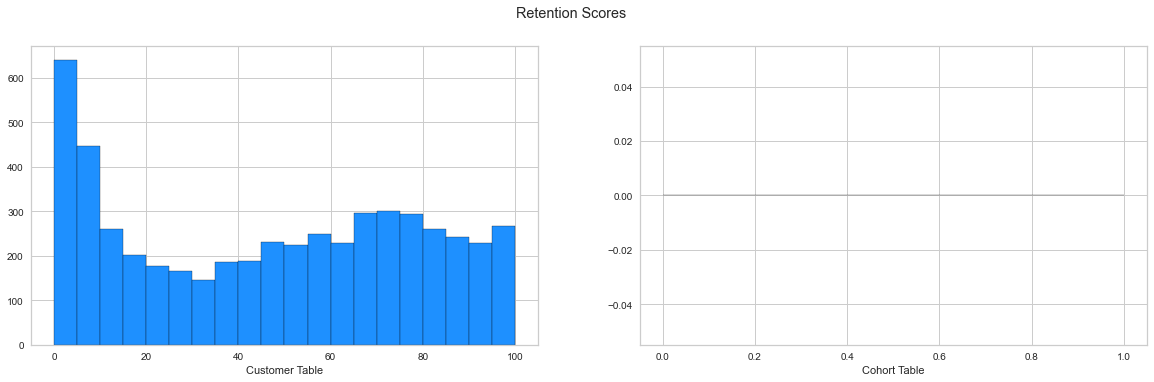

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_customer_scores['sascore'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_cohort_scores['score'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('Customer Table')
ax2.set_xlabel('Cohort Table')

fig.figure.set_figwidth(20)